In [1]:
# ============================================
# Uber Fares Project — Setup & Imports
# ============================================

import os, sys, glob
from pathlib import Path
from datetime import timedelta

# Numerical / Data
import numpy as np
import pandas as pd
import polars as pl

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Optional (weather + geospatial)
from meteostat import Hourly, Point
import geopandas as gpd

# ============================================
# Configurable paths
# Change this to point to your dataset folder
# ============================================
BASE_DIR = os.getcwd()
DATA_DIR   = os.path.join(BASE_DIR,"Uber-Data") # <-- CHANGE HERE for SDSC/Mac/Windows
DATA_FILE  = "fhvhv_tripdata_2025-04.parquet"         # Example single month parquet file

# Taxi zones files — these will be auto-detected later
ZONES_SHP  = os.path.join(DATA_DIR, "taxi_zones.shp")
ZONES_CSV  = os.path.join(DATA_DIR, "taxi_zone_lookup.csv")

# ============================================
# Settings
# ============================================
SEED            = 42
SAMPLE_ROWS     = None   # small run on laptop; set None for full SDSC run
WX_COORD_ROUND  = 3         # rounding for lat/lon centroids
USE_WEATHER     = True      # toggle weather enrichment

In [2]:
# ============================================
# Holiday Calendar (Aug 2024 – Jun 2025)
# Federal holidays in window; add major NYC events if you want
# ============================================
US_HOLIDAYS = {
    # 2024 (Aug–Dec)
    "2024-09-02": "LaborDay",
    "2024-10-14": "ColumbusDay",
    "2024-11-11": "VeteransDay",
    "2024-11-28": "Thanksgiving",
    "2024-12-25": "Christmas",
    # 2025 (Jan–Jun)
    "2025-01-01": "NewYearsDay",
    "2025-01-20": "MLKDay",
    "2025-02-17": "PresidentsDay",
    "2025-05-26": "MemorialDay",
}

# Optional (NYC local impact days — uncomment if desired)
# US_HOLIDAYS.update({
#     "2024-11-03": "NYCMarathon",
#     "2025-03-17": "StPatricksDay",
# })

In [3]:
# ============================================
# Taxi Zone Centroids
# - Prefer shapefile centroids
# - Fallback: borough anchors from CSV
# ============================================
def load_zone_centroids(zones_shp: str, zones_csv: str, round_nd=2):
    if os.path.exists(zones_shp):
        gdf = gpd.read_file(zones_shp).to_crs("EPSG:4326")
        # Some shapefiles include duplicate LocationIDs; keep first
        gdf = gdf.drop_duplicates(subset=["LocationID"])
        cents = gdf.geometry.centroid
        df = pd.DataFrame({
            "LocationID": gdf["LocationID"].astype(int),
            "lat": cents.y.round(round_nd),
            "lon": cents.x.round(round_nd),
        })
        return df.set_index("LocationID")[["lat","lon"]].to_dict(orient="index")

    if os.path.exists(zones_csv):
        df = pd.read_csv(zones_csv)
        # Borough anchors (coarse fallback)
        borough_coords = {
            "Manhattan": (40.78, -73.96),
            "Queens": (40.73, -73.82),
            "Brooklyn": (40.65, -73.95),
            "Bronx": (40.85, -73.87),
            "Staten Island": (40.58, -74.15),
        }
        df["lat"] = df["borough"].map(lambda b: borough_coords.get(b, (40.7,-73.9))[0])
        df["lon"] = df["borough"].map(lambda b: borough_coords.get(b, (40.7,-73.9))[1])
        keep = df[["LocationID","lat","lon"]].drop_duplicates(subset=["LocationID"])
        return keep.set_index("LocationID")[["lat","lon"]].to_dict(orient="index")

    raise FileNotFoundError("No taxi zones shapefile or CSV found.")

zone_centroids = load_zone_centroids(ZONES_SHP, ZONES_CSV, round_nd=WX_COORD_ROUND)
print(f"Centroids loaded for {len(zone_centroids)} zones")

Centroids loaded for 260 zones


In [8]:
# ============================================
# Build Features (Polars) for ALL months in DATA_DIR
# - samples SAMPLE_PER_FILE rows per file (set None for all)
# - stacks into a single df_pl
# - holidays fixed
# ============================================

# How many rows to take PER FILE (None = use all rows in each file)
SAMPLE_PER_FILE = 500_000   # e.g., 500k per month -> ~5.5M if 11 months
# Optional overall cap after stacking (None = no cap)
TOTAL_ROW_CAP   = None

def build_features_one_month(parquet_path: str, sample_rows=None, seed=42) -> pl.DataFrame:
    lf = pl.scan_parquet(parquet_path)

    lf = lf.filter(pl.col("base_passenger_fare") > 0)
    schema = lf.collect_schema()
    if 'cbd_congestion_fee' not in schema:
        lf = lf.with_columns(pl.lit(0.0).alias('cbd_congestion_fee').cast(pl.Float32))
    if 'hvfhs_license_num' in schema:
        lf = lf.filter(pl.col('hvfhs_license_num') == 'HV0003').drop('hvfhs_license_num')  # Uber FHV only

    # Time & basics
    lf = lf.with_columns([
        pl.col("pickup_datetime").dt.date().alias("pickup_date"),
        pl.col("pickup_datetime").dt.truncate("1h").alias("pickup_hour_dt"),
        pl.col("pickup_datetime").dt.hour().alias("pickup_hour"),
        pl.col("pickup_datetime").dt.weekday().alias("pickup_weekday"),
        pl.col("pickup_datetime").dt.month().alias("pickup_month"),
        (pl.col("trip_time")/60.0).alias("trip_minutes"),
        (pl.col("trip_miles")/(pl.col("trip_time")/3600.0 + 1e-3)).alias("avg_mph"),
        (pl.col("PULocationID").cast(pl.Utf8) + "_" + pl.col("DOLocationID").cast(pl.Utf8)).alias("RouteID_cat"),
    ])

    # Buckets & indicators
    lf = lf.with_columns([
        pl.when(pl.col("trip_miles") < 1).then(0)
          .when(pl.col("trip_miles") < 3).then(1)
          .when(pl.col("trip_miles") < 5).then(2)
          .when(pl.col("trip_miles") <10).then(3)
          .otherwise(4).alias("distance_category"),
        pl.when(pl.col("pickup_hour").is_between(7, 9)).then(1).otherwise(0).alias("morning_rush"),
        pl.when(pl.col("pickup_hour").is_between(17,19)).then(1).otherwise(0).alias("evening_rush"),
        pl.when(pl.col("pickup_hour").is_between(0, 4)).then(1).otherwise(0).alias("late_night"),
        (pl.col("pickup_weekday") >= 5).cast(pl.Int8).alias("weekend"),
    ])

    # ✅ Holidays (expects US_HOLIDAYS dict defined earlier in notebook)
    lf = lf.with_columns([
        pl.col("pickup_date").cast(pl.Utf8).replace(US_HOLIDAYS).fill_null("None").alias("holiday_name"),
        (pl.col("pickup_date").cast(pl.Utf8).is_in(list(US_HOLIDAYS.keys()))).cast(pl.Int8).alias("is_holiday"),
    ])

    df = lf.collect(streaming=True)
    if sample_rows:
        df = df.sample(n=sample_rows, seed=seed)
    return df

# ---- Load ALL files in DATA_DIR and stack ----
PATTERN = "fhvhv_tripdata_*.parquet"
files = sorted(glob.glob(os.path.join(DATA_DIR, PATTERN)))
if not files:
    raise FileNotFoundError(f"No parquet files in {DATA_DIR} matching {PATTERN}")

print(f"Found {len(files)} files:")
for f in files:
    print("  -", Path(f).name)

dfs = []
total_rows = 0
for f in files:
    print(f"\nProcessing {Path(f).name} …")
    df_part = build_features_one_month(f, sample_rows=SAMPLE_PER_FILE, seed=SEED)
    print("  -> got", df_part.shape, "rows,cols")
    dfs.append(df_part)
    total_rows += df_part.height
    if TOTAL_ROW_CAP is not None and total_rows >= TOTAL_ROW_CAP:
        print(f"Reached TOTAL_ROW_CAP={TOTAL_ROW_CAP:,}. Stopping early.")
        break

# Stack all months
df_pl = pl.concat(dfs, how="vertical_relaxed")
print("\nALL-MONTHS Polars frame:", df_pl.shape)
df_pl.head(3)

Found 12 files:
  - fhvhv_tripdata_2024-07.parquet
  - fhvhv_tripdata_2024-08.parquet
  - fhvhv_tripdata_2024-09.parquet
  - fhvhv_tripdata_2024-10.parquet
  - fhvhv_tripdata_2024-11.parquet
  - fhvhv_tripdata_2024-12.parquet
  - fhvhv_tripdata_2025-01.parquet
  - fhvhv_tripdata_2025-02.parquet
  - fhvhv_tripdata_2025-03.parquet
  - fhvhv_tripdata_2025-04.parquet
  - fhvhv_tripdata_2025-05.parquet
  - fhvhv_tripdata_2025-06.parquet

Processing fhvhv_tripdata_2024-07.parquet …


  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2024-08.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2024-09.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2024-10.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2024-11.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2024-12.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2025-01.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2025-02.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2025-03.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2025-04.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2025-05.parquet …
  -> got (500000, 32) rows,cols

Processing fhvhv_tripdata_2025-06.parquet …
  -> got (500000, 32) rows,cols

ALL-MONTHS Polars frame: (6000000, 32)


request_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,cbd_congestion_fee,pickup_date,pickup_hour_dt,pickup_hour,pickup_weekday,pickup_month,trip_minutes,avg_mph,RouteID_cat,distance_category,morning_rush,evening_rush,late_night,weekend,holiday_name,is_holiday
datetime[μs],datetime[μs],datetime[μs],i32,i32,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,date,datetime[μs],i8,i8,i8,f64,f64,str,i32,i32,i32,i32,i8,str,i8
2024-07-26 09:28:13,2024-07-26 09:31:07,2024-07-26 09:50:28,83,95,8.11,1161,30.5,0.0,0.84,2.7,0.0,0.0,2.29,22.32,"""N""",0.0,2024-07-26,2024-07-26 09:00:00,9,5,7,19.35,25.069552,"""83_95""",3,1,0,0,1,"""2024-07-26""",0
2024-07-11 16:56:35,2024-07-11 17:00:32,2024-07-11 17:20:02,234,186,1.43,1170,18.69,0.0,0.55,1.76,2.75,0.0,4.98,14.81,"""N""",0.0,2024-07-11,2024-07-11 17:00:00,17,4,7,19.5,4.386503,"""234_186""",1,0,1,0,0,"""2024-07-11""",0
2024-07-31 14:04:57,2024-07-31 14:08:53,2024-07-31 14:52:27,186,138,9.94,2614,48.41,6.94,1.4,5.14,2.75,2.5,0.0,38.92,"""N""",0.0,2024-07-31,2024-07-31 14:00:00,14,3,7,43.566667,13.670538,"""186_138""",3,0,0,0,0,"""2024-07-31""",0


In [9]:
# ============================================
# Weather Join via Meteostat (robust dtypes)
# - Pull hourly weather per PU zone centroid
# - Aggregate by (pickup_date, pickup_hour)
# - Cast to match df_pl dtypes, then join
# ============================================
from datetime import timedelta
import pandas as pd
from meteostat import Hourly, Point

def add_weather_from_centroids(df_pl: pl.DataFrame,
                               zone_centroids: dict,
                               use_weather: bool = True) -> pl.DataFrame:
    if not use_weather:
        return df_pl

    # --- Ensure join keys in df_pl are the expected dtypes
    df_pl = df_pl.with_columns([
        pl.col("pickup_date").cast(pl.Date),
        pl.col("pickup_hour").cast(pl.Int32)
    ])

    # --- Determine period
    start_date = pd.to_datetime(df_pl.select(pl.col("pickup_date").min()).item())
    end_date   = pd.to_datetime(df_pl.select(pl.col("pickup_date").max()).item()) + timedelta(days=1)

    # --- Unique PU zone ids present in sample
    pu_ids = df_pl.select(pl.col("PULocationID").unique()).to_series().to_list()

    wx_chunks = []
    for loc in pu_ids:
        try:
            loc_int = int(loc)
        except Exception:
            continue
        if loc_int not in zone_centroids:
            continue

        lat = zone_centroids[loc_int]["lat"]
        lon = zone_centroids[loc_int]["lon"]

        try:
            w = Hourly(Point(lat, lon), start_date, end_date).fetch()
        except Exception:
            continue
        if w is None or len(w) == 0:
            continue

        w = w.reset_index()
        w["pickup_date"] = w["time"].dt.strftime("%Y-%m-%d")
        w["pickup_hour"] = w["time"].dt.hour.astype("int64")

        cols_keep = ["pickup_date", "pickup_hour"]
        for c in ["temp", "prcp", "wspd", "rhum", "snow"]:
            if c in w.columns:
                cols_keep.append(c)
        wx_chunks.append(w[cols_keep])

    if not wx_chunks:
        return df_pl

    wx_df = pd.concat(wx_chunks, ignore_index=True)

    wx_hourly = (
        wx_df.groupby(["pickup_date", "pickup_hour"], as_index=False).mean(numeric_only=True)
    )

    wx_pl = pl.from_pandas(wx_hourly)

    # ✅ FIX: use `format=` instead of `fmt=`
    wx_pl = wx_pl.with_columns([
        pl.col("pickup_date").str.strptime(pl.Date, format="%Y-%m-%d", strict=False),
        pl.col("pickup_hour").cast(pl.Int32)
    ])

    for c in ["temp", "prcp", "wspd", "rhum", "snow"]:
        if c in wx_pl.columns:
            wx_pl = wx_pl.with_columns(pl.col(c).cast(pl.Float32))

    df_out = df_pl.join(
        wx_pl,
        on=["pickup_date", "pickup_hour"],
        how="left",
    )

    new_cols = []
    if "prcp" in df_out.columns:
        new_cols.append(
            pl.when(pl.col("prcp").fill_null(0) > 0).then(1).otherwise(0).alias("is_precip")
        )
    if "snow" in df_out.columns:
        new_cols.append(
            pl.when(pl.col("snow").fill_null(0) > 0).then(1).otherwise(0).alias("is_snow")
        )
    if new_cols:
        df_out = df_out.with_columns(new_cols)

    return df_out

# Run
df_pl = add_weather_from_centroids(df_pl, zone_centroids, use_weather=USE_WEATHER)
print("Weather columns present:",
      [c for c in ["temp","prcp","wspd","rhum","snow","is_precip","is_snow"] if c in df_pl.columns])

Weather columns present: ['temp', 'prcp', 'wspd', 'rhum', 'snow', 'is_precip', 'is_snow']


In [10]:
# ============================================
# Build X/y (pandas) & Train/Test Split
# ============================================
target = "base_passenger_fare"

drop_cols = {
    "pickup_datetime","dropoff_datetime","request_datetime",
    "pickup_hour_dt","holiday_name",
    "driver_pay","tips"  # not for prediction target
}
drop_cols = [c for c in drop_cols if c in df_pl.columns]

df_pl = df_pl.drop(drop_cols)  # keep useful engineered columns

# Keep a copy for slicing later
meta_cols = ["pickup_hour","pickup_weekday","distance_category"]
meta_cols = [c for c in meta_cols if c in df_pl.columns]
meta = df_pl.select(meta_cols).to_pandas()

# Select features (numeric only)
df_pd = df_pl.to_pandas()
y = df_pd[target].astype(np.float32)
X = df_pd.drop(columns=[target])

# Convert non-numeric to numeric (safe fill)
X = X.select_dtypes(include=[np.number]).fillna(0).astype(np.float32)

X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X, y, meta, test_size=0.2, random_state=SEED
)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes: (4800000, 28) (1200000, 28) (4800000,) (1200000,)


In [11]:
# ============================================
# Train XGB & Report Metrics (fast hist mode)
# ============================================

# Optional row limit (None = use all rows)
ROW_LIMIT = 0   # Example: ~500k rows per month across 11 months

if ROW_LIMIT:
    X_train_small = X_train.iloc[:ROW_LIMIT, :]
    y_train_small = y_train.iloc[:ROW_LIMIT]
else:
    X_train_small = X_train
    y_train_small = y_train

model = xgb.XGBRegressor(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=2000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    n_jobs=-1,
    tree_method="hist",        # Use "gpu_hist" if GPUs available on SDSC
    objective="reg:squarederror"
)

model.fit(X_train_small, y_train_small)

y_pred = model.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))

print("=== FINAL METRICS ===")
print(f"MSE : {mse:.2f}")
print(f"RMSE: ${rmse:.2f}")

=== FINAL METRICS ===
MSE : 16.16
RMSE: $4.02


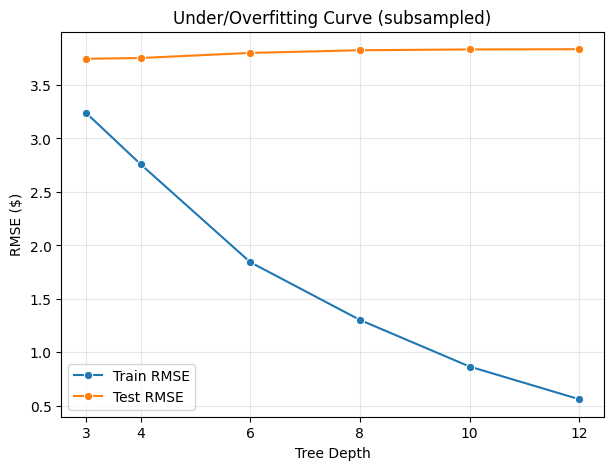

Depths     : [3, 4, 6, 8, 10, 12]
Train RMSE : [3.24, 2.758, 1.843, 1.303, 0.868, 0.562]
Test  RMSE : [3.745, 3.752, 3.8, 3.825, 3.832, 3.834]


In [13]:
# ============================================
# Under/Overfitting curve (fast, no re-imports)
# - uses existing X_train, y_train, X_test, y_test
# - trains on a subset of train for speed
# ============================================

# Config (tweak as you like)
DEPTHS = [3, 4, 6, 8, 10, 12]
N_EST  = 600          # fewer trees to keep this fast
SUB_N  = min(300_000, len(X_train))  # train subset size for this diagnostic
RS     = 42

# Subsample train once
rng = np.random.default_rng(RS)
sub_idx = rng.choice(len(X_train), size=SUB_N, replace=False)
X_tr_sub = X_train.iloc[sub_idx]
y_tr_sub = y_train.iloc[sub_idx] if hasattr(y_train, "iloc") else y_train[sub_idx]

train_rmses, test_rmses = [], []

for d in DEPTHS:
    m = xgb.XGBRegressor(
        max_depth=d,
        learning_rate=0.05,
        n_estimators=N_EST,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RS,
        n_jobs=-1,
        tree_method="hist",           # switch to "gpu_hist" on SDSC if GPUs are available
        objective="reg:squarederror",
    )
    m.fit(X_tr_sub, y_tr_sub)

    pred_tr = m.predict(X_tr_sub)
    pred_te = m.predict(X_test)

    rmse_tr = float(np.sqrt(mean_squared_error(y_tr_sub, pred_tr)))
    rmse_te = float(np.sqrt(mean_squared_error(y_test,   pred_te)))

    train_rmses.append(rmse_tr)
    test_rmses.append(rmse_te)

# Plot
plt.figure(figsize=(7,5))
try:
    sns.lineplot(x=DEPTHS, y=train_rmses, marker="o", label="Train RMSE")
    sns.lineplot(x=DEPTHS, y=test_rmses,  marker="o", label="Test RMSE")
except Exception:
    plt.plot(DEPTHS, train_rmses, marker="o", label="Train RMSE")
    plt.plot(DEPTHS, test_rmses,  marker="o", label="Test RMSE")

plt.xlabel("Tree Depth")
plt.ylabel("RMSE ($)")
plt.title("Under/Overfitting Curve (subsampled)")
plt.xticks(DEPTHS)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Depths     :", DEPTHS)
print("Train RMSE :", [round(x, 3) for x in train_rmses])
print("Test  RMSE :", [round(x, 3) for x in test_rmses])